In [130]:
# coding: utf-8
# Copyright (c) 2018 - Present Bill Thompson (billdthompson@berkeley.edu)  

import numpy as np
import pandas as pd
import wordfreq as wf
import editdistance as ed
from scipy.stats import pearsonr
import click
import scipy
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim

import os
from tqdm import tqdm
from sklearn.decomposition import PCA

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import logging
logging.basicConfig(format='%(levelname)s > %(message)s', level=logging.INFO)

AL = wf.available_languages()

def vectors(v):
    return pd.read_csv(v, header = None).values

def run(vectorfile1, vectorfile2, l1, l2, wordlistfile):
    wordlist = pd.read_csv(wordlistfile)

    A = np.array(vectors(vectorfile1))
    B = np.array(vectors(vectorfile2))
    
    pca = PCA(n_components=2)
    pca.fit(np.concatenate((A, B), axis=0))
    
    A = pca.transform(A)
    B = pca.transform(B)

    A = A / np.linalg.norm(A, axis=1, keepdims=True)
    B = B / np.linalg.norm(B, axis=1, keepdims=True)
    
    A = A[idxs]
    B = B[idxs]

    # A = (A - A_mean) / A_std
    # B = (B - B_mean) / B_std  

    M = B.T @ A
    U, S, VT = scipy.linalg.svd(M)

    W = U @ VT


    proj_A = A @ W.T

    # aligner = get_alignment(A, B, n_iter=50000)
    # proj_A = aligner(A)

    errors = -((proj_A - B) ** 2).mean(axis=-1)

    return A, B, W, proj_A, wordlist, errors

In [166]:
vectorfile1 = '../compute-alignment/en-es.v1'
vectorfile2 = '../compute-alignment/en-es.v2'
l1 = 'en'
l2 = 'es'
wordlistfile = '../compute-alignment/en-es.wordlist'

errors = None
while errors is None or -errors.mean() > 0.02:
    idxs = np.random.randint(len(wordlist), size=n_words)

    A, B, W, proj_A, wordlist, errors = run(vectorfile1, vectorfile2, l1, l2, wordlistfile)
    print(errors.mean())

-0.08990790869293087
-0.04967251051740198
-0.047858029224084775
-0.05489605131701677
-0.12282337953946383
-0.07544329930333428
-0.06624340038231122
-0.1755014950477024
-0.1242275181936052
-0.08662837463119875
-0.12922906976379805
-0.06852398683532009
-0.10643482379537868
-0.0516016862655686
-0.09402643483528585
-0.11338213045937051
-0.12777094479925502
-0.06548078907060897
-0.028225039544659936
-0.07801129814245851
-0.04630163275632395
-0.07453707884454548
-0.056537953491289906
-0.12689127964016747
-0.06902662652277931
-0.14176436105295182
-0.06334687443808318
-0.11441415528171814
-0.09074955795898956
-0.09318096955706873
-0.2053032424512713
-0.059005908600340065
-0.07390365237967607
-0.05511513528277255
-0.038677766054534456
-0.07517689457952487
-0.06333954988283733
-0.0945580277837413
-0.07598214962083315
-0.08531130155147111
-0.05813023702457789
-0.0908361814842835
-0.0184878133425858


In [167]:
# min_idx, min_error = None, None
n_words = 5

# for i in range(len(wordlist)):
#     mean_error = errors[i:i+n_words].mean()
#     if min_idx is None or mean_error < min_error:
#         min_idx = i
#         min_error = mean_error
# idxs = range(min_idx, min_idx + n_words)

words_en = wordlist['en'].to_numpy()[idxs]
words_es = wordlist['es'].to_numpy()[idxs]
print(words_en)

['thou' 'glass' 'meaning' 'track' 'full']


In [168]:
def get_bounding(pts):
    min_corner = pts[:, 0].min(), pts[:, 1].min()
    max_corner = pts[:, 0].max(), pts[:, 1].max()
    coords =  [[min_corner[0], min_corner[1]],
            [min_corner[0], max_corner[1]],
            [max_corner[0], max_corner[1]],
            [max_corner[0], min_corner[1]],
            [min_corner[0], min_corner[1]]]
    return zip(*coords)

In [169]:
A_t = A
B_t = B
pA_t = proj_A

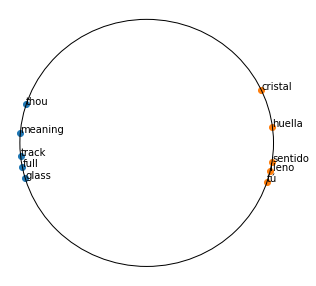

In [185]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(A_t[:, 0], A_t[:, 1], label='English')
ax.scatter(B_t[:, 0], B_t[:, 1], label='Spanish')
# ax.scatter(pA_t[idxs, 0], pA_t[idxs, 1], label='Transformed English')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
draw_circle = plt.Circle((0, 0), 1, fill=False)
ax.add_artist(draw_circle)
for i in range(n_words):
    ax.annotate(words_en[i], (A_t[:, 0][i], A_t[:, 1][i]))
    ax.annotate(words_es[i], (B_t[:, 0][i], B_t[:, 1][i]))
# plt.plot(*get_bounding(A_t[idxs]))
plt.axis('off')
plt.savefig('words_embed.pdf')
plt.savefig('words_embed.png')

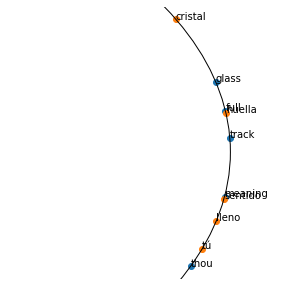

In [186]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(A_t[idxs, 0], A_t[idxs, 1], label='Transformed English')
ax.scatter(pA_t[:, 0], pA_t[:, 1], label='Transformed English')

ax.scatter(B_t[:, 0], B_t[:, 1], label='Spanish')
plt.xlim([0.6, 1.1])
# plt.ylim([-1.1, 1.1])
draw_circle = plt.Circle((0, 0), 1, fill=False)
ax.add_artist(draw_circle)
for i in range(n_words):
    ax.annotate(words_en[i], (pA_t[:, 0][i], pA_t[:, 1][i]))
    ax.annotate(words_es[i], (B_t[:, 0][i], B_t[:, 1][i]))
# plt.plot(*get_bounding(A_t[idxs]))
plt.axis('off')
plt.savefig('words_embed_transformed.pdf')
plt.savefig('words_embed_transformed.png')

In [173]:
idxs

array([716, 206, 246, 198, 584])